In [119]:
# Importing Dependincies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [120]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [121]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [122]:
# Creating engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [123]:
# Reflecting an existing database into a new model
Base = automap_base()
# Reflecting the tables
Base.prepare(autoload_with=engine)

In [124]:
# Viewing all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [125]:
# Also view all of the classes using inspector
inspector.get_table_names()

['measurement', 'station']

In [126]:
# Saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [127]:
# Creating our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [128]:
# Displaying the Measurement row's columns and data in dictionary format
first_row = session.query(Measurement).first()
print(first_row.__dict__)

# Inspecting and displaying the Measurement row's columns type
inspector = inspect(engine)
measurement_columns = inspector.get_columns("Measurement")
for i in measurement_columns:
    print(i["name"], i["type"])

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000017C5C5937D0>, 'tobs': 65.0, 'station': 'USC00519397', 'date': '2010-01-01', 'prcp': 0.08, 'id': 1}
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [129]:
# Finding the most recent date in the data set, 2 options shown below;

# most_recent_date = session.query(func.max(Measurement.date)).first()
# most_recent_date

most_recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print("Most Recent Measurement Date is: ", most_recent_date)

Most Recent Measurement Date is:  ('2017-08-23',)


In [130]:
# Calculating the date one year from the last date in data set
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Year Ago Date is: ", year_ago)


Year Ago Date is:  2016-08-23


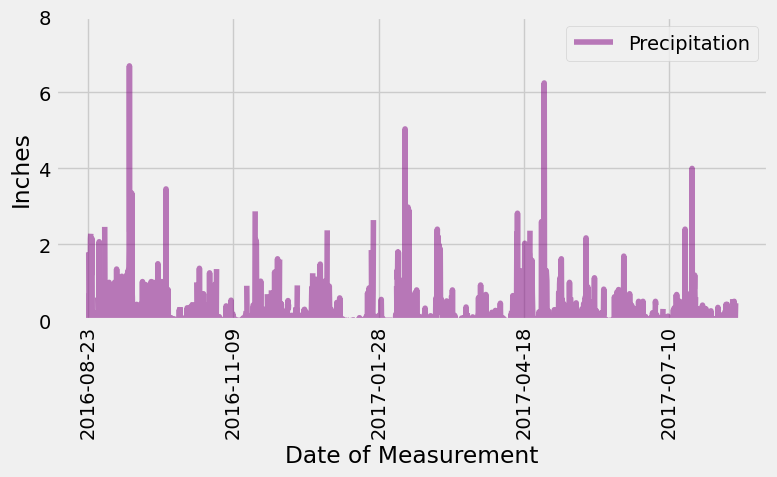

In [160]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results, starting from the most recent data point in the database 

# Saving the query results as a Pandas DataFrame. Explicitly set the column names and sorting by date
one_year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).all()
df = pd.DataFrame(one_year_data, columns=["date", "Precipitation"])
df.set_index("date", inplace=True)
df = df.sort_values("date")

# Using Pandas Plotting with Matplotlib to plot the data
df.plot(color="purple", alpha=0.5, figsize=(8,5))
plt.ylim(0, 8)
plt.xticks(rotation=90)
plt.xlabel("Date of Measurement")
plt.ylabel("Inches")
plt.tight_layout()

#saving to Output folder as jpg
plt.savefig("Output/Precipitation by Date of Measurement.jpg")
plt.show()

# why cant I get more dates data in bar chart??????????????????

In [142]:
# Using Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [134]:
# Displaying the Station row's columns and data in dictionary format
first_row = session.query(Station).first()
print(first_row.__dict__)

# Inspecting and displaying the Station row's columns type
inspector = inspect(engine)
station_columns = inspector.get_columns("Station")
for column in station_columns:
    print(column["name"], column["type"])

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000017C5F682950>, 'latitude': 21.2716, 'elevation': 3.0, 'name': 'WAIKIKI 717.2, HI US', 'id': 1, 'longitude': -157.8168, 'station': 'USC00519397'}
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [161]:
# Designing a query to calculate the total number of stations in the dataset
total_number_of_stations = session.query(func.count(Station.station)).first()
total_number_of_stations

(9,)

In [136]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


In [137]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [138]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [139]:
# Close Session
session.close()